- VGGNet is invented by VGG (Visual Geometry Group) from University of Oxford

<img src=attachment:image.png width=600>
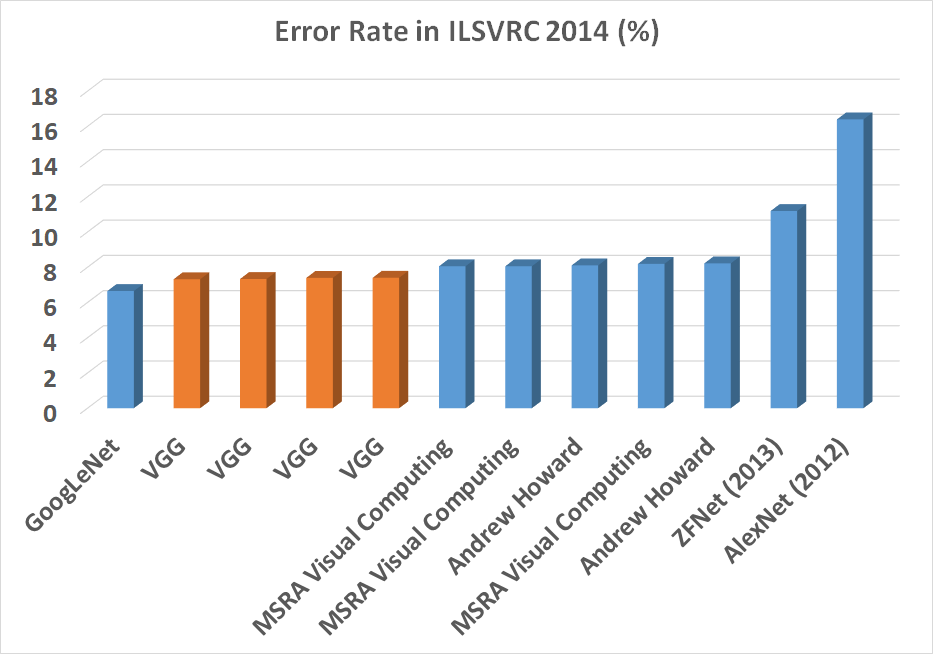

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:1")

In [2]:
# MNIST dataset
cifar_train = datasets.CIFAR10(root='CIFAR10_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

cifar_test = datasets.CIFAR10(root='CIFAR10_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
epochs = 15
batch_size = 128

valid_ratio = 0.1

In [4]:
num_train = len(cifar_train)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_ratio * num_train))

In [5]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          sampler=train_sampler,
                                          drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          sampler=valid_sampler,
                                          drop_last=True)

In [7]:
def vaild_loss(model_valid):
    avg_loss = 0
    with torch.no_grad():
        model_valid.eval()
        for images, labels in valid_loader:
            pred = model_valid(images.to(device))
            criterion = nn.CrossEntropyLoss().to(device)
            loss = criterion(pred, labels.to(device))
            avg_loss+= loss.item()
    
    return avg_loss / len(valid_loader)

In [8]:
import torchvision.models.vgg as vgg

In [9]:
cnn_config = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'simplified' : [64,64,'M',128,128,'M',256,256,'M']
}

In [10]:
cnn_model = vgg.make_layers(cnn_config['D'])  #vgg16 Conv Module을 Load

In [11]:
cnn_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

- 하지만 기존 VGG 구조를 가져오면 max pooling을 5번 해서 CIFAR10 이미지 크기가 [1,1]로 축소됨

In [12]:
xx = torch.Tensor(10,3,32,32)
output = cnn_model(xx)
print(output.shape)

torch.Size([10, 512, 1, 1])


- 원래 ImageNet 크기 224x224를 적용하면

In [13]:
xx = torch.Tensor(10,3,224,224)
output = cnn_model(xx)
print(output.shape)

torch.Size([10, 512, 7, 7])


- 그러므로 본 실험에서는 simplified VGG를 새로 정의해서 사용

In [14]:
cnn_model = vgg.make_layers(cnn_config['simplified'])

In [15]:
xx = torch.Tensor(10,3,32,32)
output = cnn_model(xx)
print(output.shape)

torch.Size([10, 256, 4, 4])


In [16]:
class VGG(nn.Module):

    def __init__(self, cnn_features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.cnn_features = cnn_features
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        out = self.cnn_features(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [17]:
vggnet= VGG(cnn_model,10,True).to(device)

- optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) : 5번 step()을 하면 0.9씩 decay

In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(vggnet.parameters(), lr=0.0005)

lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.90)

In [19]:
total_batch = len(train_loader)
vggnet.train()
best_valid = np.inf

for epoch in range(epochs):
    avg_loss = 0
    lr_schedule.step()

    for X, Y in train_loader:
        X = X.to(device) #img
        Y = Y.to(device) #label

        pred = vggnet(X)
        loss = criterion(pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch
    
    loss_valid = vaild_loss(vggnet)
    print('Epoch:{}, train loss:{:.5f}, valid loss:{:.5f}'.format(epoch, avg_loss, loss_valid))

    if loss_valid < best_valid:
        torch.save(vggnet.state_dict(), './saves/models/vggnet_cifar10.pth')
        best_valid = loss_valid

Epoch:0, train loss:1.69328, valid loss:1.37776
Epoch:1, train loss:1.09956, valid loss:0.97159
Epoch:2, train loss:0.80854, valid loss:0.78040
Epoch:3, train loss:0.63673, valid loss:0.69063
Epoch:4, train loss:0.50282, valid loss:0.66516
Epoch:5, train loss:0.36776, valid loss:0.63506
Epoch:6, train loss:0.26613, valid loss:0.68420
Epoch:7, train loss:0.16830, valid loss:0.78642
Epoch:8, train loss:0.10811, valid loss:0.88907
Epoch:9, train loss:0.07325, valid loss:0.91971
Epoch:10, train loss:0.04129, valid loss:1.04574
Epoch:11, train loss:0.03259, valid loss:1.08763
Epoch:12, train loss:0.03370, valid loss:1.15722
Epoch:13, train loss:0.01766, valid loss:1.28393
Epoch:14, train loss:0.02763, valid loss:1.22445


In [20]:
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, batch_size=128, shuffle=False)

In [21]:
correct = 0
total = 0
model_test = VGG(cnn_model,10,True).to(device)
model_test.load_state_dict(torch.load('./saves/models/vggnet_cifar10.pth'))

with torch.no_grad():
    model_test.eval()
    for images, labels in test_loader:
        output = model_test(images.to(device))
        _, predicted = torch.max(output, dim=1)        
        total += labels.size(0)
        correct += (predicted ==labels.to(device)).sum().item()

print('Accuracy on test images with simplified VGG:', (correct / total))

Accuracy on test images with simplified VGG: 0.7938
